In [ ]:
!pip install -q wget
!pip install -q segmentation_models_pytorch

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 


In [ ]:
import json
with open('/content/export-2020-07-24T06_18_59.824Z.json') as f:
  data = json.load(f)

In [ ]:
#download data

import os
import urllib.request
from urllib.error import HTTPError

from tqdm import tqdm_notebook as tqdm

def download_custom_data(custom_data_path, json_file):
    if not os.path.exists(custom_data_path):
        os.mkdir(custom_data_path)
    images_path = os.path.join(custom_data_path, "images")
    if not os.path.exists( os.path.join(custom_data_path, "images") ):
        os.mkdir(images_path)
    masks_path = os.path.join(custom_data_path, "masks")
    if not os.path.exists( os.path.join(custom_data_path, "masks") ):
        os.mkdir(masks_path)

    for datarow in tqdm(data):
        id = datarow["ID"]

        #download image
        urllib.request.urlretrieve(datarow["Labeled Data"], os.path.join(images_path, id + ".jpg"))

        #download_mask
        for label_object in datarow["Label"]["objects"]:
            try:
                urllib.request.urlretrieve(label_object["instanceURI"], os.path.join(masks_path, id + "_" + label_object["value"] + ".jpg"))
            except urllib.error.HTTPError as err:
                print(err.code)

In [ ]:
root = "/content/drive/My Drive/SS"
custom_data_path = os.path.join( root , "custom_data_1200")

In [ ]:
if not os.path.exists(custom_data_path):
    download_custom_data(custom_data_path,data)

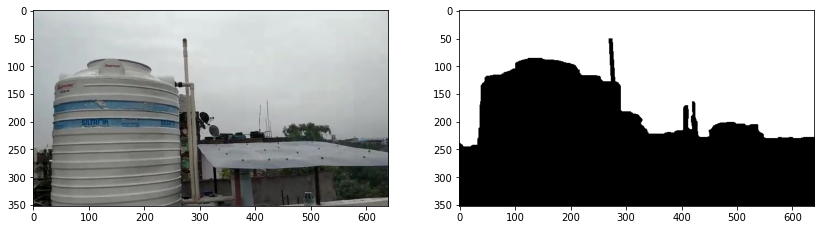

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt

images_path = os.path.join(custom_data_path, "images")
masks_path = os.path.join(custom_data_path, "masks")
images_list = [ os.path.join(images_path , path) for path in os.listdir(images_path)]

idx = random.randint(0, len(images_list))
image_path = images_list[idx]
image = cv2.imread( image_path )

mask_paths = [os.path.join(masks_path, path) for path in os.listdir(masks_path) if image_path.split("/")[-1].split(".")[0] in path]

mask = cv2.imread( mask_paths[0] )

fig, axes = plt.subplots(1,2, figsize=(14,8))
axes[0].imshow( cv2.cvtColor( image, cv2.COLOR_BGR2RGB))
axes[1].imshow(mask)

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images_list,masks_list, transform=None):
        self.path_list = [{"image":image_path,
                           "mask": { path.split("_")[-1].split(".")[0] :path for path in masks_list if image_path.split("/")[-1].split(".")[0] in path} } for image_path in images_list]
        self.transform = transform

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self,idx):

        data = self.path_list[idx]
        #print(data)

        org_image = cv2.imread(data["image"])

        if "sky" in data["mask"].keys():
            sky = cv2.imread(data["mask"]["sky"],0)
        else:
            sky = np.zeros(org_image.shape[:2] , org_image.dtype)
        
        if self.transform is not None:
            transformed = self.transform({"image": org_image, "mask": sky})
        else:
            transformed = {"image": org_image, "mask": sky}

        return transformed

def collate(batch):
    batch_size = len(batch)

    imgs = []
    msks = []
    for b in batch:
        imgs.append(b["image"])
        msks.append(b["mask"])

    imgs = torch.cat(imgs)
    msks = torch.cat(msks)

    return {"images": imgs,
            "masks": msks}

In [ ]:
import yaml
import random
import preprocess as pp
from torch.utils.data import DataLoader

with open("config.yaml") as f:
    config = yaml.load(f)

images_list = [ os.path.join(images_path , path) for path in os.listdir(images_path)]
masks_list = [ os.path.join(masks_path , path) for path in os.listdir(masks_path)]

split = int(abs(0.8*len(images_list)))
train_images_list = images_list[:split]

val_images_list = images_list[split:]

mean = config["train"]["normalize"]["imagenet"]["mean"]
std = config["train"]["normalize"]["imagenet"]["std"]

transform = {"train" : pp.Compose([pp.Rescale((512,720)),
                     pp.RandomCrop(512,True),
                     pp.Normalize_Image_and_Correct_Mask(mean,std)]),
            "val" : pp.Compose([pp.Rescale((512,512)),
                                pp.Normalize_Image_and_Correct_Mask(mean,std)]) }

train_dataset = CustomDataset(train_images_list,masks_list,transform["train"])
val_dataset = CustomDataset(val_images_list,masks_list, transform["val"])

batch_size = 8 #config["train"]["batch_size"]

train_dl = DataLoader(train_dataset,
                     batch_size=batch_size,
                     shuffle=True,
                      collate_fn = collate)

val_dl = DataLoader(val_dataset,
                    batch_size= batch_size,
                    collate_fn = collate)

In [ ]:
print("Training Data ",len(train_dataset))
print("Validation Data ",len(val_dataset))

Training Data  975
Validation Data  244


In [ ]:
import numpy as np

# DeNormalization of Tensor
def deNormalize(tensor,mean,std):
    tensor_copy = tensor.detach().clone()
    for t, m, s in zip(tensor_copy, mean, std):
        t.mul_(s).add_(m)
    return tensor_copy
# Get a Batch from DataLoader
it = iter(train_dl)


In [ ]:
print(len(train_dataset),len(val_dataset))
x = next(it)
print(x["images"].shape, x["masks"].shape)

975 244
torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])


In [ ]:
# select an instance of a batch and denormalize it
img = x["images"][0]
msk = x["masks"][0]
print(img.shape, msk.shape)
print(img.min() , img.max())

dn_img = deNormalize(img, mean, std)
print( dn_img.min(), dn_img.max())

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
tensor(-2.1179) tensor(1136.3572)
tensor(0.) tensor(255.0000)


(512, 512, 3)
torch.Size([512, 512])


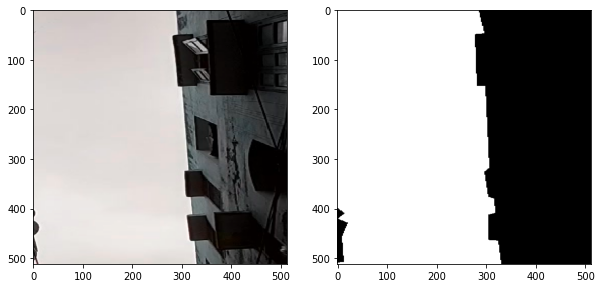

In [ ]:
# plot denormalized data instance
import utils
import numpy as np
image = np.array( np.floor( np.transpose(dn_img , (1,2,0)))).astype(np.int64)
print(image.shape)
mask = np.squeeze(msk, 0)
print(mask.shape)
fig , axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].imshow(image)
axes[1].imshow( mask ,cmap="gray")

In [ ]:
import torch
import segmentation_models_pytorch as smp

#model = smp.Unet('mobilenet_v2', classes=2, activation=None, encoder_weights='imagenet')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
epochs = 100
#weights_path = "/content/drive/My Drive/models/mobilenet_v2_1_weights.pth"
save_path = "/content/drive/My Drive/SS/models/SS_CustomData1200_resnet34.pt" #config["train"]["save_path"]

In [ ]:
# model.load_state_dict(torch.load(weights_path))

In [ ]:
# outputs = model(x["images"])
# targets = utils.expand_target(x["masks"])
# print(outputs.shape, targets.shape)

In [ ]:
def get_metrics(output, target, epoch, history, mode, smooth = 1):

    bce_loss_mean, bce_loss_batch = loss.BCE_loss_batch(output, target.float())
    history["BCE_loss"].setdefault(epoch, {}).setdefault(mode , []).extend([l.item() for l in bce_loss_batch])

    dice_score_mean, dice_score_batch = loss.DICEScore_batch(output, target.float(), smooth)
    history["DICEScore"].setdefault(epoch, {}).setdefault(mode , []).extend([l.item() for l in dice_score_batch])

    iou_score_mean, iou_score_batch = loss.IoUScore_batch(output, target.float(), smooth)
    history["IoUScore"].setdefault(epoch, {}).setdefault(mode , []).extend([l.item() for l in iou_score_batch])    

    return bce_loss_mean

def print_metrics(epoch, history, mode, length):
    print("{} || BCELoss {:.4f} || DICEScore {:.4f} || IoUScore {:.4f}".
          format(mode,
                 sum(history["BCE_loss"][epoch][mode])/length[mode],
                 sum(history["DICEScore"][epoch][mode])/length[mode],
                 sum(history["IoUScore"][epoch][mode])/length[mode]))


In [ ]:
import loss
from tqdm.notebook import tqdm
import time
from torch.autograd import Variable

length = {"train":len(train_dataset), "val":len(val_dataset)}

def train():
    best_loss = np.inf
    cnt_since_last_improvement = 0
    patience = 15
    history = {"IoUScore":{}, "BCE_loss":{}, "DICEScore":{}}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch , epochs-1))
        print("=="*20)
        start = time.time()
        model.train()
        
        mode = "train"
        for sample in tqdm(train_dl):
            
            inputs = sample['images'].to(device)
            target = utils.expand_target( sample['masks'].to(device) )
            
            optimizer_ft.zero_grad()
            output = model(inputs)
            
            mode_loss = get_metrics(output, target, epoch, history, mode)
            mode_loss.backward()
            optimizer_ft.step()
        print_metrics(epoch, history, mode, length)
        
        model.eval()
        mode = "val"
        for sample in tqdm(val_dl):

            inputs = sample['images'].to(device)
            target = utils.expand_target( sample['masks'].to(device) )
            output = model(inputs)

            mode_loss = get_metrics(output, target, epoch, history, mode)
            mode_loss.backward()
        print_metrics(epoch, history, mode, length)

        cnt_since_last_improvement += 1

        if sum(history["BCE_loss"][epoch][mode])/length[mode] < best_loss:
            cnt_since_last_improvement = 0
            print("Saving Best Model...")
            best_loss = sum(history["BCE_loss"][epoch][mode])/length[mode]
            torch.save(model.state_dict(), weights_path)
            # torch.save(model, save_path)

        print("Epoch time ",(time.time() - start)//60,"minutes")
        print("Best Validation Loss ", best_loss)

        if cnt_since_last_improvement >= patience:
            print("================> Early Stopping! <=================")
            break
        


In [ ]:
import torch
save_path = "/content/drive/My Drive/SS/models/SS_CustomData1200_resnet34.pt"
model = torch.load(save_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.Batch

In [ ]:
import torch
import loss
from tqdm.notebook import tqdm
length = {"train":len(train_dataset), "val":len(val_dataset)}
save_path = "/content/drive/My Drive/SS/models/SS_CustomData1200_resnet34.pt"
model = torch.load(save_path)
model.to(device)
epoch = 0
history = {"IoUScore":{}, "BCE_loss":{}, "DICEScore":{}}

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [ ]:
model.eval()
mode = "train"
for sample in tqdm(train_dl):    
    inputs = sample['images'].to(device)
    target = utils.expand_target( sample['masks'].to(device) )
    output = model(inputs)
    mode_loss = get_metrics(output, target, epoch, history, mode)
print_metrics(epoch, history, mode, length)

mode = "val"
for sample in tqdm(val_dl):
    inputs = sample['images'].to(device)
    target = utils.expand_target( sample['masks'].to(device) )
    output = model(inputs)
    mode_loss = get_metrics(output, target, epoch, history, mode)
print_metrics(epoch, history, mode, length)


train || BCELoss 0.0706 || DICEScore 0.9673 || IoUScore 0.9436



val || BCELoss 0.1327 || DICEScore 0.9481 || IoUScore 0.9192


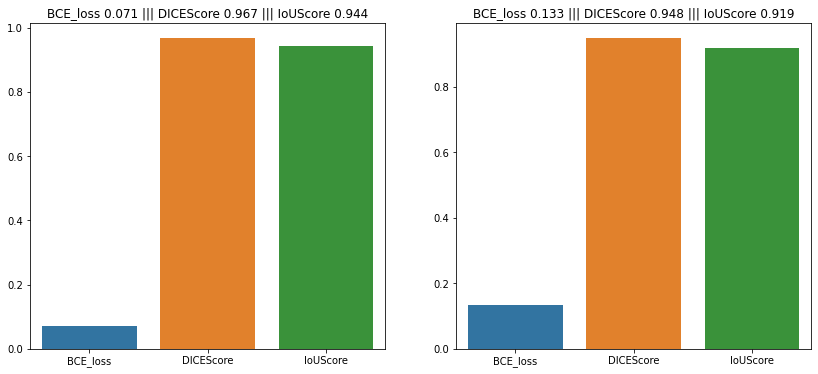

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].set_title("BCE_loss {:.3f} ||| DICEScore {:.3f} ||| IoUScore {:.3f}".format(sum(history["BCE_loss"][0]["train"])/length["train"],
                                                            sum(history["DICEScore"][0]["train"])/length["train"],
                                                            sum(history["IoUScore"][0]["train"])/length["train"]))
sns.barplot(x = ["BCE_loss", "DICEScore", "IoUScore"], y = [ sum(history["BCE_loss"][0]["train"])/length["train"],
                                                            sum(history["DICEScore"][0]["train"])/length["train"],
                                                            sum(history["IoUScore"][0]["train"])/length["train"]], ax = ax[0])
ax[1].set_title("BCE_loss {:.3f} ||| DICEScore {:.3f} ||| IoUScore {:.3f}".format(sum(history["BCE_loss"][0]["val"])/length["val"],
                                                            sum(history["DICEScore"][0]["val"])/length["val"],
                                                            sum(history["IoUScore"][0]["val"])/length["val"]))
sns.barplot(x = ["BCE_loss", "DICEScore", "IoUScore"], y = [ sum(history["BCE_loss"][0]["val"])/length["val"],
                                                            sum(history["DICEScore"][0]["val"])/length["val"],
                                                            sum(history["IoUScore"][0]["val"])/length["val"]], ax = ax[1])

In [ ]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import functional
import utils

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def predict(image_path, model):
    org_img = cv2.imread(image_path)
    org_shape = org_img.shape[:2]
    resized = cv2.resize(org_img, (512,512), interpolation=cv2.INTER_NEAREST)
    transposed = np.transpose(resized, (2, 0, 1))
    image_tensor = torch.from_numpy(transposed).float()
    image = functional.normalize(image_tensor, mean, std)
    image = image[None,...]
    pred = model(image.to(device))
    pred_mask = torch.round(torch.sigmoid(pred))[0][0]
    pred_mask = cv2.resize(pred_mask.detach().cpu().numpy(), (org_shape[1],org_shape[0] ), interpolation=cv2.INTER_NEAREST)
    return {"image": org_img, "mask": pred_mask}

def show(sample):
    fig, axes = plt.subplots(1,2 ,figsize=(10,6))
    axes[0].imshow(sample["image"])
    axes[1].imshow(sample["mask"], cmap = "gray")
    plt.show()

def save_mask(sample, image_path, mask_path):
    """
    Save the mask on mask_path with name as image_name + "_mask.jpg"
    """
    to_save_ = np.float32( utils.correct_binary( sample["mask"], True) )
    filename = os.path.join( mask_path , image_path.split("/")[-1].split(".")[0] + "_mask" + ".jpg" )
    cv2.imwrite(filename, to_save_)



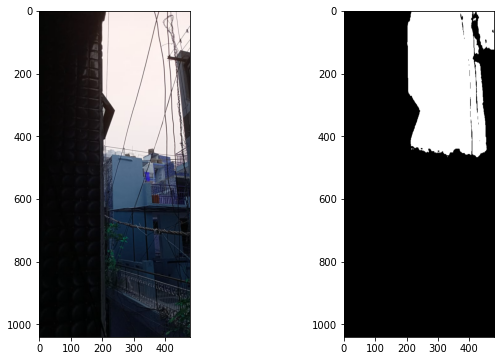

In [ ]:
model.to(device)
sample = predict("test3.jpg",model)
show(sample)

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/files.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/files")

In [ ]:
import os
from pathlib import Path

images_paths = sorted(Path("/content/drive/My Drive/files").glob("**/*.jpg"))
len(images_paths)

233

In [ ]:
for image_path in images_paths:
    masks_path = os.path.join( str(image_path.parent.parent), "Masks")
    if not os.path.exists( masks_path ):
        os.mkdir(masks_path)

In [ ]:
from tqdm.notebook import tqdm

for image_path in tqdm(images_paths):
    sample = predict(str(image_path), model)
    masks_path = os.path.join( str(image_path.parent.parent), "Masks")
    to_save_ = np.float32( utils.correct_binary( sample["mask"], True) )
    filename = os.path.join( masks_path , str(image_path.name) + "_mask" + ".jpg" )
    cv2.imwrite(filename, to_save_)

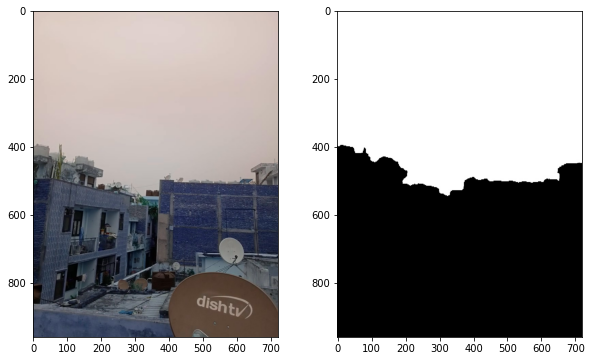

In [ ]:
# import os
# import numpy as np
# import random
# unzipped_images_path = "/content/drive/My Drive/unzipped/images"
# unzipped_images = os.listdir("/content/drive/My Drive/unzipped/images")
# unzipped_masks_path = "/content/drive/My Drive/unzipped/masks"


# def save_unzipped_masks():
#     for image_name in tqdm(unzipped_images):
#         image_path = os.path.join(unzipped_images_path, image_name)
#         sample = predict(  image_path , model )
#         save_mask(sample, image_path, unzipped_masks_path)

# #save_unzipped_masks()

# def get_mask_name(image_name, masks_path):
#     unzipped_masks = os.listdir(masks_path)
#     for path in unzipped_masks:
#         if image_name.split(".")[0] in path:
#             return path

# idx = random.randint(0, len(unzipped_images))
# data = [ (image_name, get_mask_name(image_name, unzipped_masks_path) ) for image_name in unzipped_images]
# datum = data[idx]
# image = cv2.imread( os.path.join(unzipped_images_path, datum[0]) )
# mask = cv2.imread( os.path.join(unzipped_masks_path, datum[1]) )

# show({"image":image, "mask":mask})